In [1]:
%load_ext Cython
from scipy import integrate
from scipy import interpolate
from scipy.interpolate import RectBivariateSpline
from scipy import optimize
from numpy import linalg as LA
from mpmath import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import dill
import pandas as pd
import time
sns.set()
sns.set_style('whitegrid')
sns.set_context('talk')

In [2]:
#These triple series expressions for epsilon, pi_1 and pi_2 
#are still slow for phenomenology
#alternatively, the integral expression for the generating 
#function could be used

#hbar = 0.197 #GeV * fm
hbar = 1. #only for testing

#the maxmimum number of terms kept in each series
#number of computations will scale like sum_max^3 since we
#sum over n_1, n_2 and n_3 -- this has a big effect on speed.
#one should check that the results have converged, if not - increase sum_max
sum_max = 15

method_sum='alternating'
#method_sum='direct'

gamma = memoize(gamma) #speed up mpmath

#the angular function
def angular(nx, ny, nz):
    ns = nx+ny+nz
    a = (1+(-1)**(2*nx))*(1+(-1)**(2*ny))*(1+(-1)**(2*nz))/4.
    b = gamma((1.+ (2.*nx))/2.) * gamma((1.+ (2.*ny))/2.) * gamma((1.+ (2.*nz))/2.) / gamma((3.+(2.*ns))/2.)
    return mpmathify(a*b)

angular = memoize(angular) #speed up mpmath

def sum_e_fct(beta, g1, g2):
    beta = mpmathify(beta)
    g1 = mpmathify(g1)
    g2 = mpmathify(g2)
    g3 = -(g1+g2)
    def e_fct(nx, ny, nz):
        nx = mpmathify(nx)
        ny = mpmathify(ny)
        nz = mpmathify(nz)
            
        ns = nx + ny + nz
        a = angular(nx, ny, nz) * gamma(3+ns) / (fac(nx)*fac(ny)*fac(nz))
        b = ((-g1/beta)**nx) * ((-g2/beta)**ny) * ((-g3/beta)**nz)
        c = (3+ns)
        pre_fac = 1./ ((2.*np.pi*hbar)**3.) / (beta ** 4.)
        pre_fac = mpmathify(pre_fac)
        return pre_fac*a*b*c
    return float(nsum( e_fct, [0, sum_max], [0, sum_max], [0, sum_max], method=method_sum ))
        
def sum_pi_1_fct(beta, g1, g2):
    beta = mpmathify(beta)
    g1 = mpmathify(g1)
    g2 = mpmathify(g2)
    g3 = -(g1+g2)
    def pi_1_fct(nx, ny, nz):
        nx = mpmathify(nx)
        ny = mpmathify(ny)
        nz = mpmathify(nz)
            
        ns = nx + ny + nz
        a = (-1)**(ns) * angular(nx, ny, nz) * gamma(3+ns) / (fac(nx) * fac(ny) * fac(nz))
        b = ((g1/beta)**nx) * ((g2/beta)**ny) * ((g3/beta)**nz)
        c = ( (3.+ns)/3. + (nx*beta/g1) )
        pre_fac = -1./ ((2.*np.pi*hbar)**3.) / (beta ** 4.)
        pre_fac = mpmathify(pre_fac)
        return pre_fac*a*b*c 
    return float(nsum( pi_1_fct, [0, sum_max], [0, sum_max], [0, sum_max], method=method_sum ))

def sum_pi_2_fct(beta, g1, g2):
    beta = mpmathify(beta)
    g1 = mpmathify(g1)
    g2 = mpmathify(g2)
    g3 = -(g1+g2)
    def pi_2_fct(nx, ny, nz):
        nx = mpmathify(nx)
        ny = mpmathify(ny)
        nz = mpmathify(nz)
            
        ns = nx + ny + nz
        a = (-1)**(ns) * angular(nx, ny, nz) * gamma(3+ns) / (fac(nx) * fac(ny) * fac(nz))
        b = ((g1/beta)**nx) * ((g2/beta)**ny) * ((g3/beta)**nz)
        c = ( (3.+ns)/3. + (ny*beta/g2) )
        pre_fac = -1./ ((2.*np.pi*hbar)**3.) / (beta ** 4.)
        pre_fac = mpmathify(pre_fac)
        return pre_fac*a*b*c 
    return float(nsum( pi_2_fct, [0, sum_max], [0, sum_max], [0, sum_max], method=method_sum ))

In [3]:
#the equilibrium temperature (EoS)
def equil_eps(beta):
    return 3. / (np.pi**2. * hbar**3. * beta**4.)

def equil_beta(eps):
    a = 3. / (eps * np.pi**2. * hbar**3.)
    return a**(0.25)

def beta_pi(eps):
    beta = equil_beta(eps)
    I_1_42 = 4. / (5. * np.pi**2. * hbar**3. * beta**5.)
    return beta * I_1_42

def f_CE_RTA(p, e, pi_ij, regulate=False):
    beta0 = equil_beta(e)
    beta_pi0 = beta_pi(e)
    p_0 = np.sqrt(p@p) #energy for massless case
    f_eq = np.exp(-beta*p_0)
    ang_fac = p @ pi_ij @ p
    df = beta0 * f_eq * ang_fac / (2. * p_0 * beta_pi0)
    #regulation
    if regulate:
        df = np.copysign( min(np.fabs(df), f_eq), df )
    
    return f_eq + df

In [4]:
#this root solving routine is still slow,
#but can probably be sped up with a c backend 
#and some algebraic re-arranging of the various terms
#Sage has a cython mpmath backend (https://www.sagemath.org)

def root_solve_beta_gamma(e0, pi_1, pi_2, tol=1e-4, maxiter = int(1e5)):    
    
    def my_fun(x):
        beta = x[0]
        g1 = x[1]
        g2 = x[2]
        e_val = sum_e_fct(beta, g1, g2)
        pi_1_val = sum_pi_1_fct(beta, g1, g2)
        pi_2_val = sum_pi_2_fct(beta, g1, g2)
        return [e_val - e0, pi_1_val - pi_1, pi_2_val - pi_2]
    
    def print_warning(e0, pi_1, pi_2):
        print("WARNING - NO ROOT FOUND: e0 = " + str(e0) + " ; pi_1 = " + str(pi_1))
        
    #USE Linear CE RTA to initialize the rootsolver
    beta_guess = equil_beta(e0)
    beta_pi_guess = beta_pi(e0)
    guess_fac = -beta_guess / (2. * beta_pi_guess)
    #guess_fac *= 0.95 #see if this improves performance
    g1_guess = guess_fac * pi_1 
    g2_guess = guess_fac * pi_2 
    guess = [beta_guess, g1_guess, g2_guess]
    print("guess = " + str(guess))
    
    solution = optimize.root(my_fun, guess, tol=tol) #scipy default method
    #solution = optimize.newton(my_fun, guess, tol=tol, full_output=True) #secant method
    #solution = optimize.root(my_fun, guess, method='anderson', tol=tol) #anderson method seems unstable
    
    if (solution.success == False):
        print_warning(e0, pi_1, pi_2)
        
    beta_soln = solution.x[0]
    g1_soln = solution.x[1]
    g2_soln = solution.x[2]
    
    return beta_soln, g1_soln, g2_soln, solution

In [5]:
#Checks that the functions are working correctly
t1 = time.time()
e = sum_e_fct(beta=1., g1=0.1, g2=0.2)
t2 = time.time()
pi_1 = sum_pi_1_fct(beta=1., g1=0.1, g2=0.2)
t3 = time.time()
pi_2 = sum_pi_2_fct(beta=1., g1=0.1, g2=0.2)
print("e = " + str(e) + " ?=? 49.772")
print("pi_1 = " + str(pi_1) + " ?=? -4.035")
print("pi_2 = " + str(pi_2) + " ?=? -5.5907")
print("e sum eval'd in " + str(t2-t1) + " sec")
print("pi_1 sum eval'd in " + str(t3-t2) + " sec")

e = 0.3805388499192862 ?=? 49.772
pi_1 = -0.030858088047567938 ?=? -4.035
pi_2 = -0.04274594241455485 ?=? -5.5907
e sum eval'd in 1.6782047748565674 sec
pi_1 sum eval'd in 0.7080812454223633 sec


In [6]:
#Check the root solving method
root_solve_beta_gamma(e, pi_1, pi_2, tol=1e-7, maxiter = int(1e5))

guess = [0.9453782948269218, 0.14373975876354222, 0.19911445716652693]


(1.000000000010021,
 0.10000000004330165,
 0.19999999992345913,
     fjac: array([[-0.99152238, -0.11542131, -0.05967657],
        [ 0.12944861, -0.9172024 , -0.37680606],
        [ 0.01124405,  0.38133669, -0.92436784]])
      fun: array([-4.13818979e-11,  1.37543102e-12,  1.60999339e-11])
  message: 'The solution converged.'
     nfev: 13
      qtf: array([-1.89020555e-09,  7.58993861e-10,  5.84002402e-10])
        r: array([ 0.80079347, -0.44114888, -0.67288836,  0.33458498,  0.3571934 ,
         0.19612121])
   status: 1
  success: True
        x: array([1. , 0.1, 0.2]))

In [7]:
def find_shear_eig(pi_ij):
    """pi_ij should be the shear stress tensor in the LRF"""
    w, v = LA.eig(pi_ij)
    return w, v

In [8]:
#this function solves for all the lagrange multipliers
#and returns them
def find_lagrange_multipliers(e, pi_xx, pi_xy, pi_xz, pi_yy, pi_yz):

    pi_zz = -(pi_xx + pi_yy) #traceless

    #symmetric matrix
    pi_ij = np.array( [[pi_xx, pi_xy, pi_xz],[pi_xy, pi_yy, pi_yz],[pi_xz, pi_yz, pi_zz]] )

    w, v = find_shear_eig(pi_ij) #w are eig vals, v is matrix of eig vectors
    #print("v.T @ v = ")
    #print(v.T @ v)

    pi_1, pi_2 = w[0], w[1] #first two eig vals

    #now root solve to find lagrange multipliers
    beta_soln, g1_soln, g2_soln, info = root_solve_beta_gamma(e, pi_1, pi_2, tol=1e-7, maxiter = int(1e5))

    g3_soln = -(g1_soln + g2_soln)
    #construct the diagonal gamma matrix
    gamma_ij_D = np.array( [[g1_soln, 0., 0.],[0., g2_soln, 0.],[0., 0., g3_soln]] )
    #now rotate gamma out of the eigenvector basis
    #gamma_ij = (v.T)@(gamma_ij_D)@(v)
    gamma_ij = (v)@(gamma_ij_D)@(v.T)
    
    return beta_soln, gamma_ij, info

In [9]:
#the ME distribution
def f_dist(p, e, pi_xx, pi_xy, pi_xz, pi_yy, pi_yz):
    """Input assumes p is a three-vector momentum."""
    beta, gamma_ij, info = find_lagrange_multipliers(e, pi_xx, pi_xy, pi_xz, pi_yy, pi_yz)
    p_0 = np.sqrt(p@p) #energy for massless case
    a = np.exp(-beta*p_0)
    b = np.exp(-p@gamma_ij@p / p_0)
    return a*b, info

#the ME distribution fast version (assumes roots found)
def f_dist_fast(p, beta, gamma_ij):
    """Input assumes p is a three-vector momentum."""
    p_0 = np.sqrt(p@p) #energy for massless case
    a = np.exp(-beta*p_0)
    b = np.exp(-p@gamma_ij@p / p_0)
    return a*b

## Plots

In [10]:
T_sw = 0.15
beta_sw = 1./T_sw
e = equil_eps(beta_sw)

#Conformal EoS
p_eq = e / 3.

R_pi_inv = 1/5.

#shear tensor
pi_xx = p_eq * R_pi_inv
pi_zz = pi_xx
pi_xy = 0.
pi_xz = 0.
pi_yz = 0.
pi_yy = -(pi_xx + pi_zz)

pi_ij = np.array( [[pi_xx, pi_xy, pi_xz],[pi_xy, pi_yy, pi_yz],[pi_xz, pi_yz, pi_zz]] )

beta, gamma_ij, info = find_lagrange_multipliers(e, pi_xx, pi_xy, pi_xz, pi_yy, pi_yz)

guess = [6.666666666666667, -0.8333333333333335, 1.666666666666667]


In [11]:
#plot angular distribution
phip_vals = np.linspace(0., 2.*np.pi, 100)
p_mag = 3. / beta_sw

f_ME_ratio = []
f_CE_ratio = []

for phip in phip_vals:
    px = p_mag * np.cos(phip)
    py = p_mag * np.sin(phip)
    pz = 0.
    p = np.array([px, py, pz])
    
    f_eq = f_dist_fast(p, beta_sw, np.zeros((3,3)))
    f_ME = f_dist_fast(p, beta, gamma_ij)
    f_CE = f_CE_RTA(p, e, pi_ij)
    
    ratio_ME = f_ME / f_eq
    ratio_CE = f_CE / f_eq
    
    f_ME_ratio.append(ratio_ME)
    f_CE_ratio.append(ratio_CE)

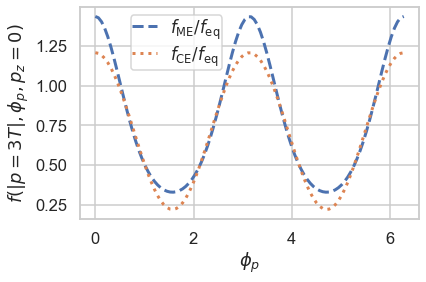

In [12]:
plt.plot(phip_vals, f_ME_ratio, label=r'$f_{\rm ME} / f_{\rm eq}$', ls='--', lw=3)
plt.plot(phip_vals, f_CE_ratio, label=r'$f_{\rm CE} / f_{\rm eq}$', ls=':', lw=3)
plt.xlabel(r'$\phi_p$')
plt.ylabel(r'$f(|p = 3T|, \phi_p, p_z=0)$')
plt.legend(loc=(.15, .7), borderpad=0.1, labelspacing=0.2, handlelength=1.5, handleheight=1.5)
plt.tight_layout(True)
plt.savefig('plots/shear_phip_dist.png', dpi=500)
plt.show()

In [13]:
T_sw = 0.15
beta_sw = 1./T_sw
e = equil_eps(beta_sw)

#Conformal EoS
p_eq = e / 3.

R_pi_inv = 1/5.

#shear tensor
pi_xx = p_eq * R_pi_inv
pi_yy = pi_xx
pi_xy = 0.
pi_xz = 0.
pi_yz = 0.
pi_zz = -(pi_xx + pi_yy)

pi_ij = np.array( [[pi_xx, pi_xy, pi_xz],[pi_xy, pi_yy, pi_yz],[pi_xz, pi_yz, pi_zz]] )

beta, gamma_ij, info = find_lagrange_multipliers(e, pi_xx, pi_xy, pi_xz, pi_yy, pi_yz)

guess = [6.666666666666667, -0.8333333333333335, -0.8333333333333335]


In [14]:
#plot angular distribution
thetap_vals = np.linspace(0., np.pi, 100)
p_mag = 3. / beta_sw

f_ME_ratio = []
f_CE_ratio = []

for thetap in thetap_vals:
    px = p_mag * np.sin(thetap)
    py = 0.
    pz = p_mag * np.cos(thetap)
    p = np.array([px, py, pz])
    
    f_eq = f_dist_fast(p, beta_sw, np.zeros((3,3)))
    f_ME = f_dist_fast(p, beta, gamma_ij)
    f_CE = f_CE_RTA(p, e, pi_ij)
    
    ratio_ME = f_ME / f_eq
    ratio_CE = f_CE / f_eq
    
    f_ME_ratio.append(ratio_ME)
    f_CE_ratio.append(ratio_CE)

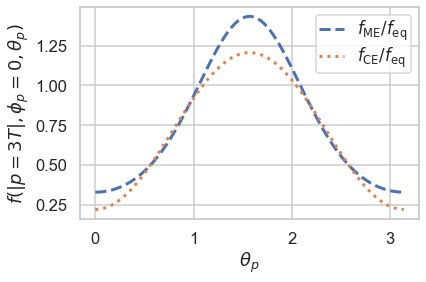

In [15]:
plt.plot(thetap_vals, f_ME_ratio, label=r'$f_{\rm ME} / f_{\rm eq}$', ls='--', lw=3)
plt.plot(thetap_vals, f_CE_ratio, label=r'$f_{\rm CE} / f_{\rm eq}$', ls=':', lw=3)
plt.xlabel(r'$\theta_p$')
plt.ylabel(r'$f(|p = 3T|, \phi_p=0, \theta_p)$')
plt.legend(borderpad=0.2, labelspacing=0.2, handlelength=1.5)
plt.tight_layout(True)
plt.savefig('plots/shear_thetap_dist.png', dpi=500)
plt.show()

In [16]:
#plot radial
p_vals = np.linspace(0.01, 5., 100)

f_ME_ratio = []
f_CE_ratio = []

for p_mag in p_vals:
    px = p_mag * T_sw
    py = 0.
    pz = 0.
    p = np.array([px, py, pz])
    
    f_eq = f_dist_fast(p, beta_sw, np.zeros((3,3)))
    f_ME = f_dist_fast(p, beta, gamma_ij)
    f_CE = f_CE_RTA(p, e, pi_ij)
    
    ratio_ME = f_ME / f_eq
    ratio_CE = f_CE / f_eq
    
    f_ME_ratio.append(ratio_ME)
    f_CE_ratio.append(ratio_CE)

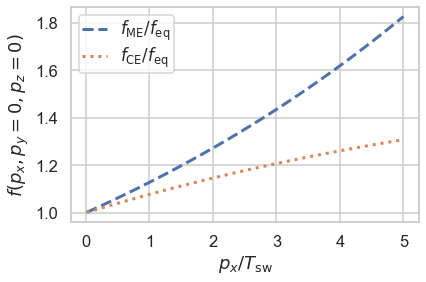

In [17]:
plt.plot(p_vals, f_ME_ratio, label=r'$f_{\rm ME} / f_{\rm eq}$', ls='--', lw=3)
plt.plot(p_vals, f_CE_ratio, label=r'$f_{\rm CE} / f_{\rm eq}$', ls=':', lw=3)
plt.xlabel(r'$p_x / T_{\rm sw}$')
plt.ylabel(r'$f(p_x, p_y=0, p_z=0)$')
plt.legend(borderpad=0.2, labelspacing=0.2, handlelength=1.5)
plt.tight_layout(True)
plt.savefig('plots/shear_px_dist.png', dpi=500)
plt.show()

In [21]:
#testing the method with no symmetries
#values of epsilon and pi_ij given by Mathematica integrals 
beta, gamma_ij, info = find_lagrange_multipliers(2.09504, 0.0445643, -0.0372869, 0.0194373, -0.122494, 0.0693331)
print(beta)
print(gamma_ij)

guess = [0.6171735388380228, 0.08441446725741893, -0.028790812652066518]
0.6240003862240583
[[-0.03140009  0.0243001  -0.01120002]
 [ 0.0243001   0.0763002  -0.04220013]
 [-0.01120002 -0.04220013 -0.04490011]]
